In [2]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import torch.nn.functional as F

import math


In [3]:

import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


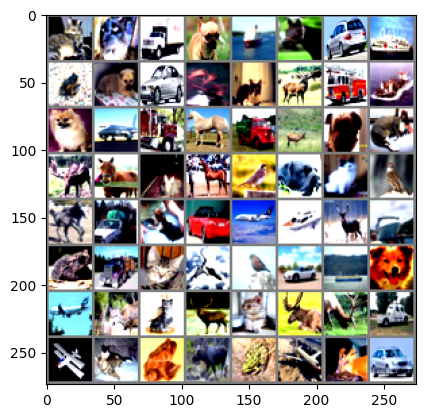

cat cat truck dog ship horse automobile ship frog dog automobile deer cat deer truck ship dog airplane truck horse truck deer dog cat deer horse cat horse bird dog cat bird horse truck dog automobile airplane ship deer ship frog truck cat airplane bird automobile ship dog airplane deer cat deer cat deer deer truck airplane cat frog deer frog airplane deer automobile


In [4]:


import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(64)))


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        self.num_patches = (self.image_size // self.patch_size) ** 2

        # Linear projection of flattened patches
        self.projection = nn.Conv2d(
            self.num_channels, 
            self.hidden_size, 
            kernel_size=self.patch_size, 
            stride=self.patch_size
        )

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class MultiHeadDifferentialAttention(nn.Module):
    """
    Implementation of Multi-Head Differential Attention mechanism
    based on the Differential Transformer paper.
    """
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Projection layers for query, key, and value
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape  # Batch, Sequence length, Embedding dimension

        # Project to query, key, value
        qkv = self.qkv_proj(x)  # (B, N, 3 * D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each is (B, num_heads, N, head_dim)

        # Compute differential keys by taking differences between consecutive tokens
        # Padding the sequence with zeros to maintain the sequence length
        k_padded = torch.cat([torch.zeros_like(k[:, :, :1, :]), k], dim=2)  # (B, num_heads, N+1, head_dim)
        diff_k = k_padded[:, :, 1:, :] - k_padded[:, :, :-1, :]  # (B, num_heads, N, head_dim)

        # Standard attention with q and differential k
        # (B, num_heads, N, head_dim) @ (B, num_heads, head_dim, N) -> (B, num_heads, N, N)
        attn_weights = torch.matmul(q, diff_k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_probs = F.softmax(attn_weights, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # Apply attention weights to values
        # (B, num_heads, N, N) @ (B, num_heads, N, head_dim) -> (B, num_heads, N, head_dim)
        context = torch.matmul(attn_probs, v)
        
        # Reshape back to original dimensions
        # (B, num_heads, N, head_dim) -> (B, N, D)
        context = context.transpose(1, 2).reshape(B, N, D)
        
        # Final projection
        out = self.out_proj(context)
        return out


class DiffViTEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        # Layer Norm 1 (for attention)
        self.norm1 = nn.LayerNorm(input_dim)
        # Multi-head differential attention (instead of standard self-attention)
        self.attn = MultiHeadDifferentialAttention(input_dim, num_heads, dropout)
        # Layer Norm 2 (for MLP)
        self.norm2 = nn.LayerNorm(input_dim)
        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pre-LayerNorm architecture as in the original paper
        # First attention block with residual connection
        x = x + self.attn(self.norm1(x))
        # Then MLP block with residual connection
        x = x + self.mlp(self.norm2(x))
        return x


class PositionalEmbedding:
    @staticmethod
    def create(embedding_type, num_patches, embed_dim, image_size=None, patch_size=None):
        if embedding_type == 'none':
            return NoPositionalEmbedding()
        elif embedding_type == '1d':
            return OneDPositionalEmbedding(num_patches, embed_dim)
        elif embedding_type == '2d':
            assert image_size is not None and patch_size is not None, "image_size and patch_size are required for 2D embeddings"
            return TwoDPositionalEmbedding(num_patches, embed_dim, image_size, patch_size)
        elif embedding_type == 'sinusoidal':
            return SinusoidalPositionalEmbedding(num_patches, embed_dim)
        else:
            raise ValueError(f"Unknown embedding type: {embedding_type}")


class NoPositionalEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x


class OneDPositionalEmbedding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
    
    def forward(self, x):
        return x + self.pos_embed


class TwoDPositionalEmbedding(nn.Module):
    def __init__(self, num_patches, embed_dim, image_size, patch_size):
        super().__init__()
        grid_size = image_size // patch_size
        
        # Create separate height and width position embeddings
        self.pos_embed_h = nn.Parameter(torch.zeros(1, grid_size, embed_dim // 2))
        self.pos_embed_w = nn.Parameter(torch.zeros(1, grid_size, embed_dim // 2))
        
        # Class token embedding (separate from the 2D grid)
        self.cls_pos_embed = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Initialize with truncated normal
        nn.init.trunc_normal_(self.pos_embed_h, std=0.02)
        nn.init.trunc_normal_(self.pos_embed_w, std=0.02)
        nn.init.trunc_normal_(self.cls_pos_embed, std=0.02)
        
        self.grid_size = grid_size
        self.embed_dim = embed_dim
    
    def forward(self, x):
        # Split input between class token and patch tokens
        cls_token = x[:, 0:1, :]  # (B, 1, D)
        patch_tokens = x[:, 1:, :]  # (B, N, D)
        
        # Get batch size
        batch_size = x.shape[0]
        
        # Reshape patch tokens to 2D grid
        patch_tokens = patch_tokens.reshape(batch_size, self.grid_size, self.grid_size, self.embed_dim)
        
        # Split embedding dimension in half for height and width components
        h_dim = w_dim = self.embed_dim // 2
        
        # Generate 2D positional embeddings: combine height and width components
        # For each position (i,j) in the grid, concatenate embeddings for row i and column j
        pos_embed_grid = torch.zeros(1, self.grid_size, self.grid_size, self.embed_dim, device=x.device)
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                pos_embed_grid[0, i, j, :h_dim] = self.pos_embed_h[0, i, :]
                pos_embed_grid[0, i, j, h_dim:] = self.pos_embed_w[0, j, :]
        
        # Add positional embedding to patch tokens
        patch_tokens = patch_tokens + pos_embed_grid
        
        # Reshape back to sequence format
        patch_tokens = patch_tokens.reshape(batch_size, self.grid_size * self.grid_size, self.embed_dim)
        
        # Add positional embedding to class token separately
        cls_token = cls_token + self.cls_pos_embed
        
        # Combine class token and patch tokens
        return torch.cat([cls_token, patch_tokens], dim=1)


class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        
        # Create position encodings for patches
        pe = torch.zeros(num_patches + 1, embed_dim)  # +1 for cls token
        position = torch.arange(0, num_patches + 1).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim)
        )
        
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as a buffer (not a parameter)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe


class DiffViTClassifierWithCustomPositionalEmbedding(nn.Module):
    def __init__(
        self, image_size, patch_size, num_channels, embed_dim, hidden_dim, num_heads,
        num_layers, num_classes, pos_embedding_type='1d', dropout=0.0
    ):
        super().__init__()
        
        # Create config for patch embedding
        patch_config = {
            "image_size": image_size,
            "patch_size": patch_size,
            "num_channels": num_channels,
            "hidden_size": embed_dim
        }
        
        # Patch embedding layer
        self.patch_embedding = PatchEmbeddings(patch_config)
        self.num_patches = self.patch_embedding.num_patches
        
        # Class token 
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Initialize class token with truncated normal distribution
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Create positional embedding based on the specified type
        self.pos_embedding = PositionalEmbedding.create(
            pos_embedding_type, self.num_patches, embed_dim, image_size, patch_size
        )
        
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder blocks with differential attention
        self.transformer = nn.Sequential(
            *[DiffViTEncoder(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )
        
        # Layer normalization for the final output
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Get batch size
        B = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embedding(x)  # (B, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + num_patches, embed_dim)
        
        # Apply positional embedding
        x = self.pos_embedding(x)
        x = self.dropout(x)
        
        # Apply transformer blocks with differential attention
        x = self.transformer(x)
        
        # Apply layer norm
        x = self.norm(x)
        
        # Use the class token for classification
        x = x[:, 0]  # (B, embed_dim)
        
        # Classification head
        x = self.head(x)  # (B, num_classes)
        
        return x



Training model with No Position Embedding
Epoch 1/20, Loss: 1.7238, Test Accuracy: 43.87%
Epoch 2/20, Loss: 1.4250, Test Accuracy: 51.90%
Epoch 3/20, Loss: 1.2865, Test Accuracy: 54.25%
Epoch 4/20, Loss: 1.1951, Test Accuracy: 56.47%
Epoch 5/20, Loss: 1.1288, Test Accuracy: 58.94%
Epoch 6/20, Loss: 1.0697, Test Accuracy: 60.42%
Epoch 7/20, Loss: 1.0210, Test Accuracy: 61.02%
Epoch 8/20, Loss: 0.9809, Test Accuracy: 61.84%
Epoch 9/20, Loss: 0.9267, Test Accuracy: 61.63%
Epoch 10/20, Loss: 0.8841, Test Accuracy: 63.03%
Epoch 11/20, Loss: 0.8445, Test Accuracy: 63.04%
Epoch 12/20, Loss: 0.8055, Test Accuracy: 64.37%
Epoch 13/20, Loss: 0.7638, Test Accuracy: 64.17%
Epoch 14/20, Loss: 0.7248, Test Accuracy: 62.87%
Epoch 15/20, Loss: 0.6810, Test Accuracy: 63.54%
Epoch 16/20, Loss: 0.6483, Test Accuracy: 63.96%
Epoch 17/20, Loss: 0.6054, Test Accuracy: 63.83%
Epoch 18/20, Loss: 0.5731, Test Accuracy: 64.06%
Epoch 19/20, Loss: 0.5344, Test Accuracy: 63.17%
Epoch 20/20, Loss: 0.4956, Test Acc

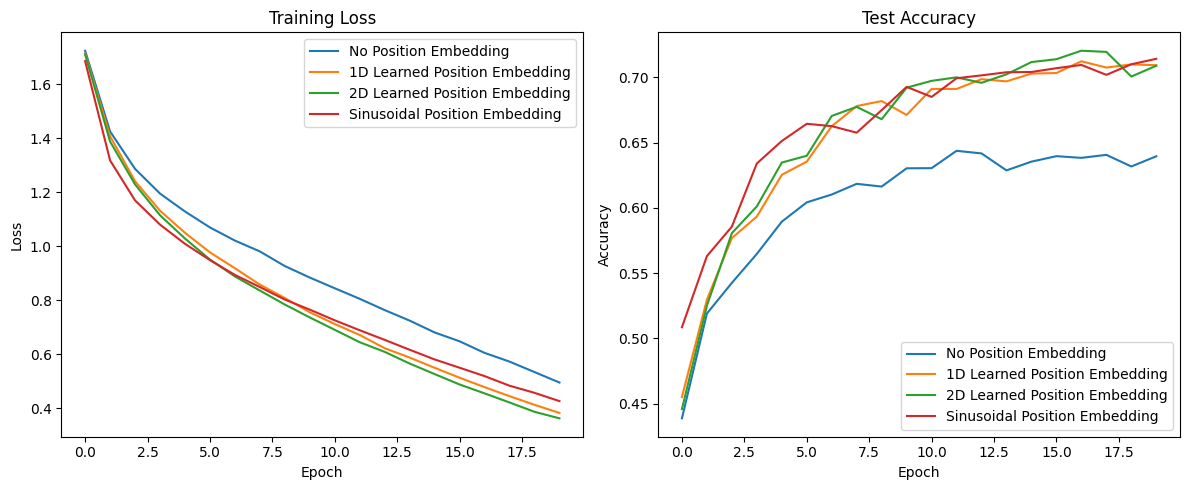

In [7]:
def train_and_evaluate(model_factory, train_loader, test_loader, num_epochs=20, device='cuda', lr=1e-4):

    model = model_factory().to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    

    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Record average training loss
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Record test accuracy
        accuracy = correct / total
        test_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2%}')
    
    return train_losses, test_accuracies


vit_config = {
        'image_size': 32,
        'patch_size': 4,
        'num_channels': 3,
        'embed_dim': 192,
        'hidden_dim': 768,
        'num_heads': 8,
        'num_layers': 6,
        'num_classes': 10,
        'dropout': 0.1
}
    

model_factories = {
    'No Position Embedding': lambda: ViTClassifierWithCustomPositionalEmbedding(
        **vit_config, pos_embedding_type='none'
    ),
    '1D Learned Position Embedding': lambda: ViTClassifierWithCustomPositionalEmbedding(
        **vit_config, pos_embedding_type='1d'
    ),
    '2D Learned Position Embedding': lambda: ViTClassifierWithCustomPositionalEmbedding(
        **vit_config, pos_embedding_type='2d'
    ),
    'Sinusoidal Position Embedding': lambda: ViTClassifierWithCustomPositionalEmbedding(
        **vit_config, pos_embedding_type='sinusoidal'
    )
    }
    
    # Train and evaluate each model variant
results = {}
for name, factory in model_factories.items():
    print(f"\nTraining model with {name}")
    train_losses, test_accuracies = train_and_evaluate(factory, trainloader, testloader, num_epochs=20, device=device)
    results[name] = (train_losses, test_accuracies)
    
    # Plot results
plt.figure(figsize=(12, 5))
    
    # Plot training losses
plt.subplot(1, 2, 1)
for name, (losses, _) in results.items():
    plt.plot(losses, label=name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
    # Plot test accuracies
plt.subplot(1, 2, 2)
for name, (_, accuracies) in results.items():
    plt.plot(accuracies, label=name)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
    
plt.tight_layout()
plt.show()
    
